# Sentiment Analysis using BERT


### Import Libraries and Set the intial variables

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

### Load the data

In [4]:
p_df = pd.read_csv("datasets/positive_user.csv")
n_df = pd.read_csv("datasets/negative_user.csv")

In [5]:
#p_df = p_df.iloc[:450000]
#n_df = n_df.iloc[:len(p_df)]
p_df = p_df.groupby('user')['text'].agg(list).reset_index()
n_df = n_df.groupby('user')['text'].agg(list).reset_index()[:len(p_df)]
p_df["label"] = [1] * len(p_df)
n_df["label"] = [0] * len(n_df)
df = pd.concat([p_df, n_df])

In [6]:
df.columns = ['user','tweet','label']

In [7]:
assert df["tweet"].apply(lambda x: isinstance(x, list)).all() # make sure each element in tweet column is a list

In [8]:
class_names = ['not depressed', 'depressed']

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [9]:
# Set the model name
model_name = 'prajjwal1/bert-tiny'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, force_download=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [10]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [11]:
max_tweets = 50
max_len = 100

In [12]:
tweets = []

for tweet_list in df['tweet'].values:
  if len(tweet_list) < max_tweets:
    tweet_list.extend([""] * (max_tweets - len(tweet_list)))
  elif len(tweet_list) > max_tweets:
    tweet_list = tweet_list[:max_tweets]
  tweets.append(tweet_list)

df['tweet'] = tweets

In [13]:
assert set([len(t) for t in df["tweet"]]) == {max_tweets} # make sure the length of each list in tweets column is max_tweets

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [14]:
from Dataset import TweetDataset

Create a 80% train data and 10% test and 10% validation data

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(3974, 3) (497, 3) (497, 3)


Create a dataloader to release data in batches.

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [17]:
batch_size = 8

# row # must be multiple of batch_size
df_train = df_train[:(len(df_train) // batch_size) * batch_size]
df_val = df_val[:(len(df_val) // batch_size) * batch_size]
df_test = df_test[:(len(df_test) // batch_size) * batch_size]

In [18]:
assert len(df_train) % batch_size == 0
assert len(df_val) % batch_size == 0
assert len(df_test) % batch_size == 0

In [19]:
print(df_train.label.value_counts())
print(df_val.label.value_counts())
print(df_test.label.value_counts())

label
0    1995
1    1973
Name: count, dtype: int64
label
1    263
0    233
Name: count, dtype: int64
label
0    252
1    244
Name: count, dtype: int64


In [20]:
# Create train, test and val data loaders

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [21]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(model_name)

In [22]:
num_lstms = 5

In [23]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)

        self.lstm = [nn.LSTM(input_size=128, hidden_size=50, num_layers=5, batch_first=True).to(device) for i in range(num_lstms)]
        self.batch = torch.nn.BatchNorm1d(self.lstm[0].hidden_size * num_lstms)
        self.out = nn.Sequential(nn.Linear(self.lstm[0].hidden_size*num_lstms, 1), nn.Sigmoid())
        

    # Forward propagation class
    def forward(self, input_ids, attention_mask):
        pooled_output = torch.zeros((batch_size, max_tweets, 128), dtype=torch.float32).to(device)
        for x in range(0 , len(input_ids)):
            _, output = self.bert(input_ids=input_ids[x], attention_mask=attention_mask[x], return_dict=False)
            output = output.to(device)
            pooled_output[:, x].copy_(output)
        
        pooled_output = pooled_output.view(batch_size, num_lstms, max_tweets//num_lstms, 128)

        lstmOut = torch.zeros((batch_size, num_lstms, self.lstm[0].hidden_size), dtype=torch.float32).to(device)
        
        for i in range(len(self.lstm)):
            lstmTempOut, _ = self.lstm[i](pooled_output[:, i, :])
            lstmOut[:, i, :] = lstmTempOut[:, -1, :]
        lstmOut = self.drop(lstmOut)
        lstmOut = lstmOut.view(batch_size, num_lstms*self.lstm[0].hidden_size)
        norm = self.batch(lstmOut)
        
       
        return self.out(norm)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [24]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [25]:
# Number of hidden units
print(bert_model.config.hidden_size)

128


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [26]:
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")  # only use cuda for training

In [27]:
# Number of iterations
EPOCHS = 10

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
'''
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
'''
scheduler = OneCycleLR(optimizer, max_lr = 1e-4, total_steps = total_steps)
# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [28]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = torch.stack(d["input_ids"]).to(device)
        attention_mask = torch.stack(d["attention_mask"]).to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs = outputs.view(-1, 1).float()
        targets = targets.view(-1, 1).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs.round() == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = torch.stack(d["input_ids"]).to(device)
            attention_mask = torch.stack(d["attention_mask"]).to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            outputs = outputs.view(-1, 1).float()
            targets = targets.view(-1, 1).float()

            #print("OUTPUT", outputs)
            #print("TARGET", targets)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs.round() == targets)
            losses.append(loss.item())

            if progress_bar:
                progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [31]:
%%time


from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)


    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")


    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:16<00:00,  3.36it/s]

Train loss 0.7196001241644544 accuracy 0.5148689516129032


Validation:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 61/62 [00:15<00:00,  7.31it/s]

Val   loss 0.651813893548904 accuracy 0.7237903225806451

Epoch 2/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:16<00:00,  4.44it/s]

Train loss 0.6551591820053516 accuracy 0.6134072580645161


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  8.89it/s]

Val   loss 0.5575219133207875 accuracy 0.7782258064516129

Epoch 3/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:19<00:00,  3.85it/s]

Train loss 0.5757894811611022 accuracy 0.7069052419354839


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  8.35it/s]

Val   loss 0.48420936205694753 accuracy 0.8366935483870968

Epoch 4/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:08<00:00,  4.35it/s]

Train loss 0.4807445182495059 accuracy 0.7857862903225806


Validation:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 61/62 [00:14<00:00,  7.83it/s]

Val   loss 0.4121024017372439 accuracy 0.8588709677419355

Epoch 5/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:25<00:00,  4.25it/s]

Train loss 0.3868022096313296 accuracy 0.8548387096774194


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  8.59it/s]

Val   loss 0.3626895993947983 accuracy 0.8911290322580645

Epoch 6/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:25<00:00,  4.24it/s]

Train loss 0.329514654623645 accuracy 0.8813004032258064


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:17<00:00,  8.40it/s]

Val   loss 0.34416603609438867 accuracy 0.877016129032258

Epoch 7/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [03:52<00:00,  4.25it/s]

Train loss 0.28460370029713355 accuracy 0.905241935483871


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  7.92it/s]

Val   loss 0.324103417656114 accuracy 0.8931451612903225

Epoch 8/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:11<00:00,  4.26it/s]

Train loss 0.25739783814717687 accuracy 0.9173387096774194


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  7.07it/s]

Val   loss 0.32108544053569915 accuracy 0.8850806451612903

Epoch 9/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:16<00:00,  4.15it/s]

Train loss 0.24265870264160536 accuracy 0.9155745967741935


Validation:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 61/62 [00:13<00:00,  8.06it/s]

Val   loss 0.31405846582305047 accuracy 0.8891129032258064

Epoch 10/10
----------


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [02:18<00:00,  3.86it/s]

Train loss 0.24308418891122263 accuracy 0.913054435483871


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  9.17it/s]

Val   loss 0.3137765834408422 accuracy 0.8911290322580645

CPU times: user 18min 46s, sys: 3min, total: 21min 47s
Wall time: 27min 12s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

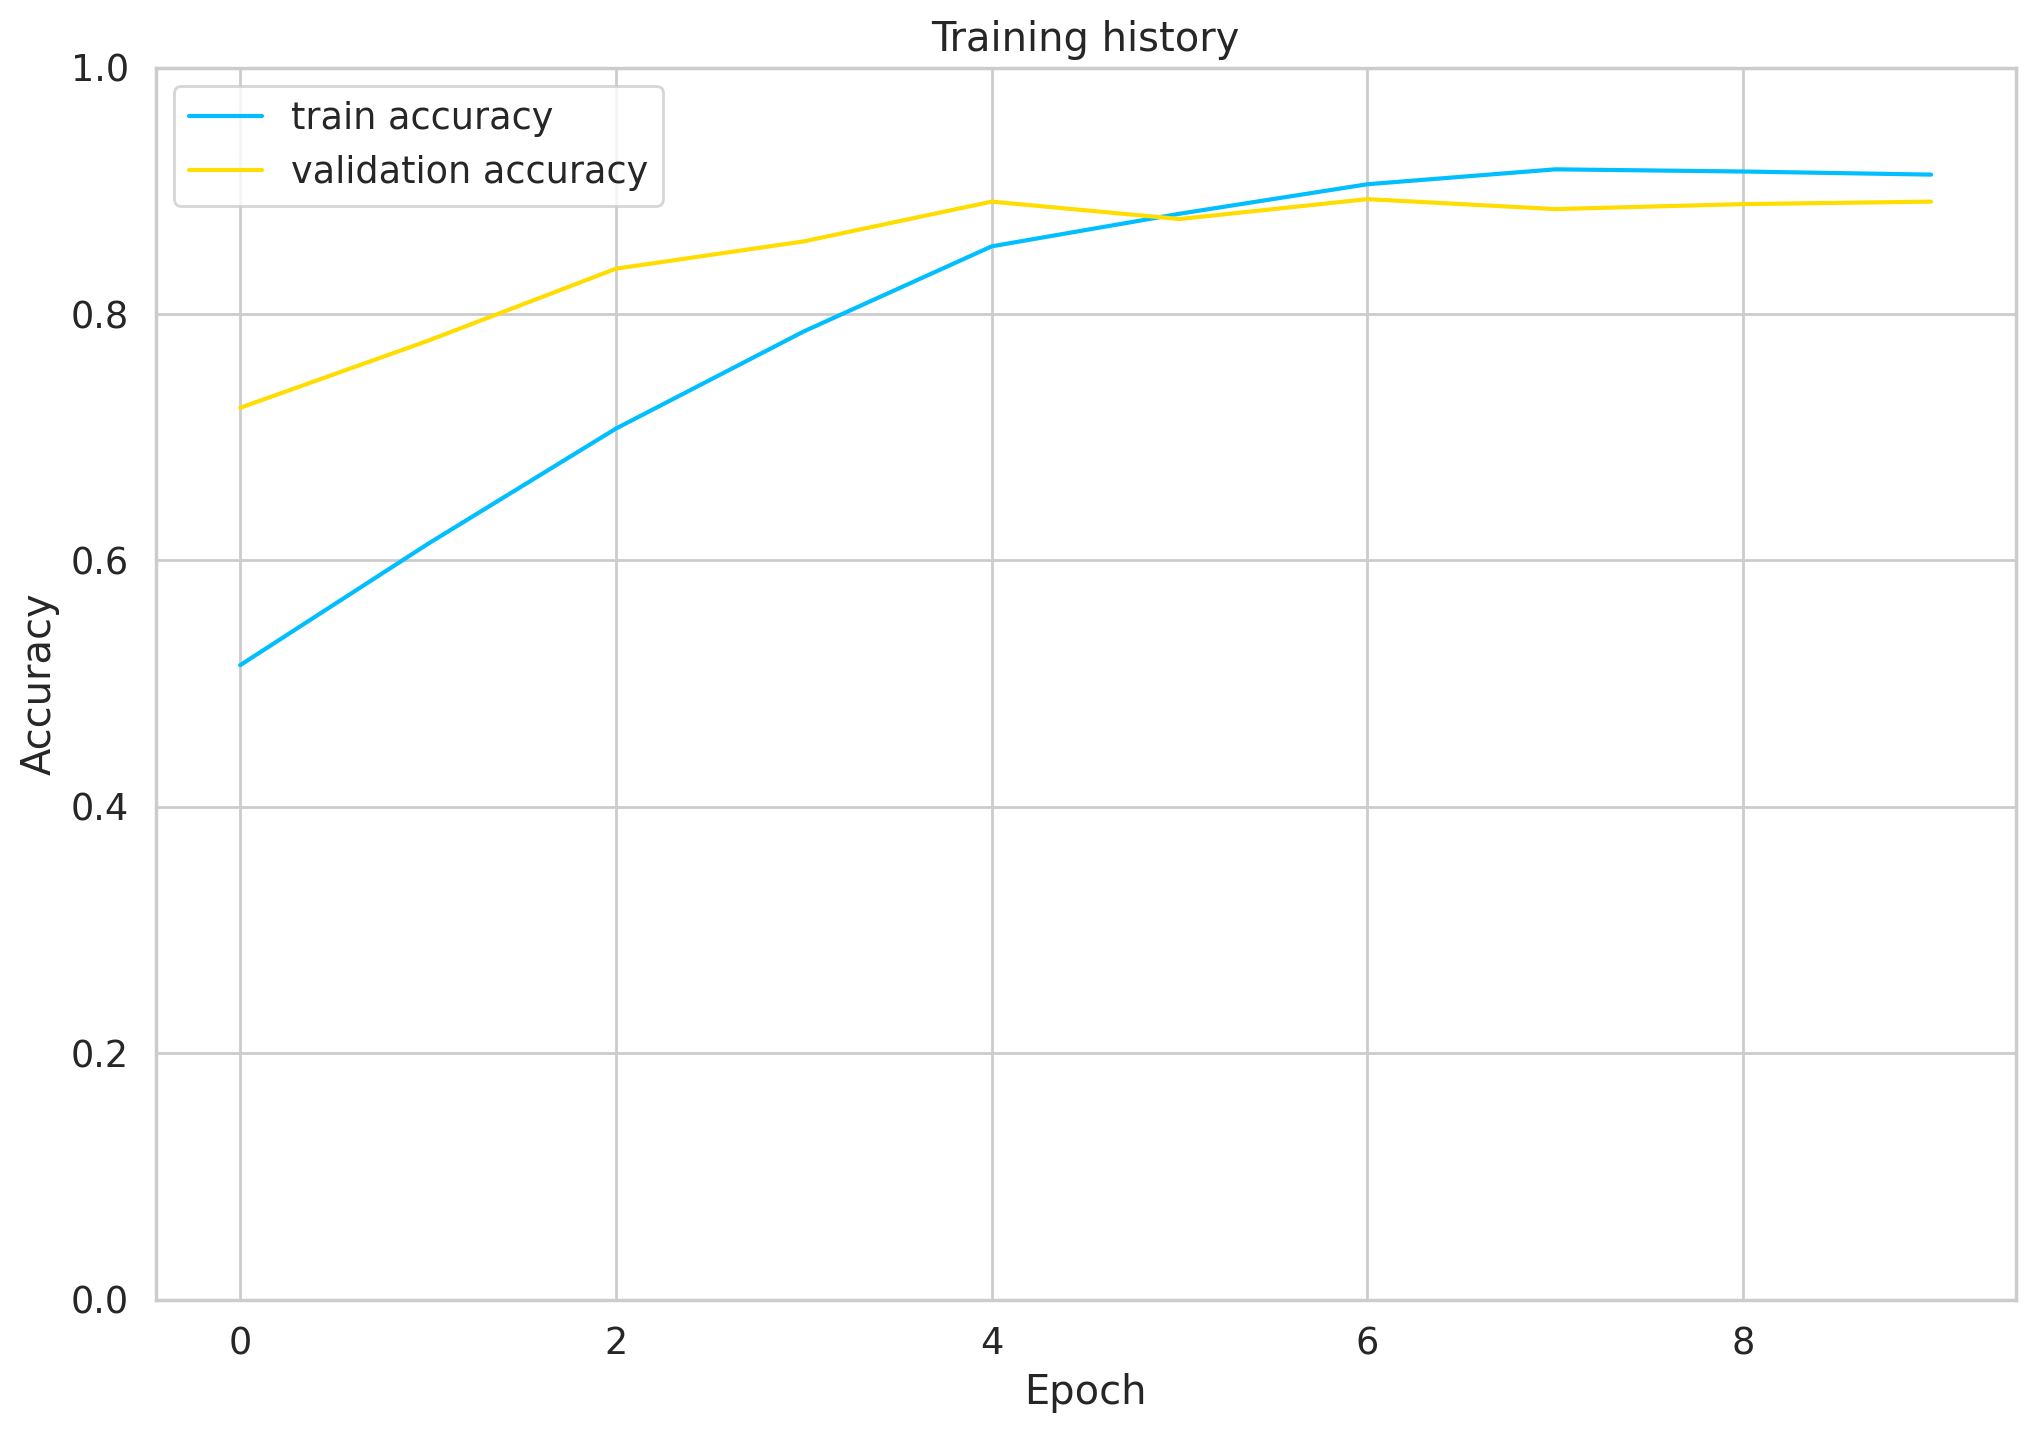

In [32]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [33]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.844758064516129

In [34]:
test_data_loader.dataset.targets

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [35]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = [x.to(device) for x in d["input_ids"]]
            attention_mask = [x.to(device) for x in d["attention_mask"]]
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.flatten(outputs.round())

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [36]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [37]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.84      0.85      0.85       252
    depressed       0.85      0.84      0.84       244

     accuracy                           0.84       496
    macro avg       0.84      0.84      0.84       496
 weighted avg       0.84      0.84      0.84       496



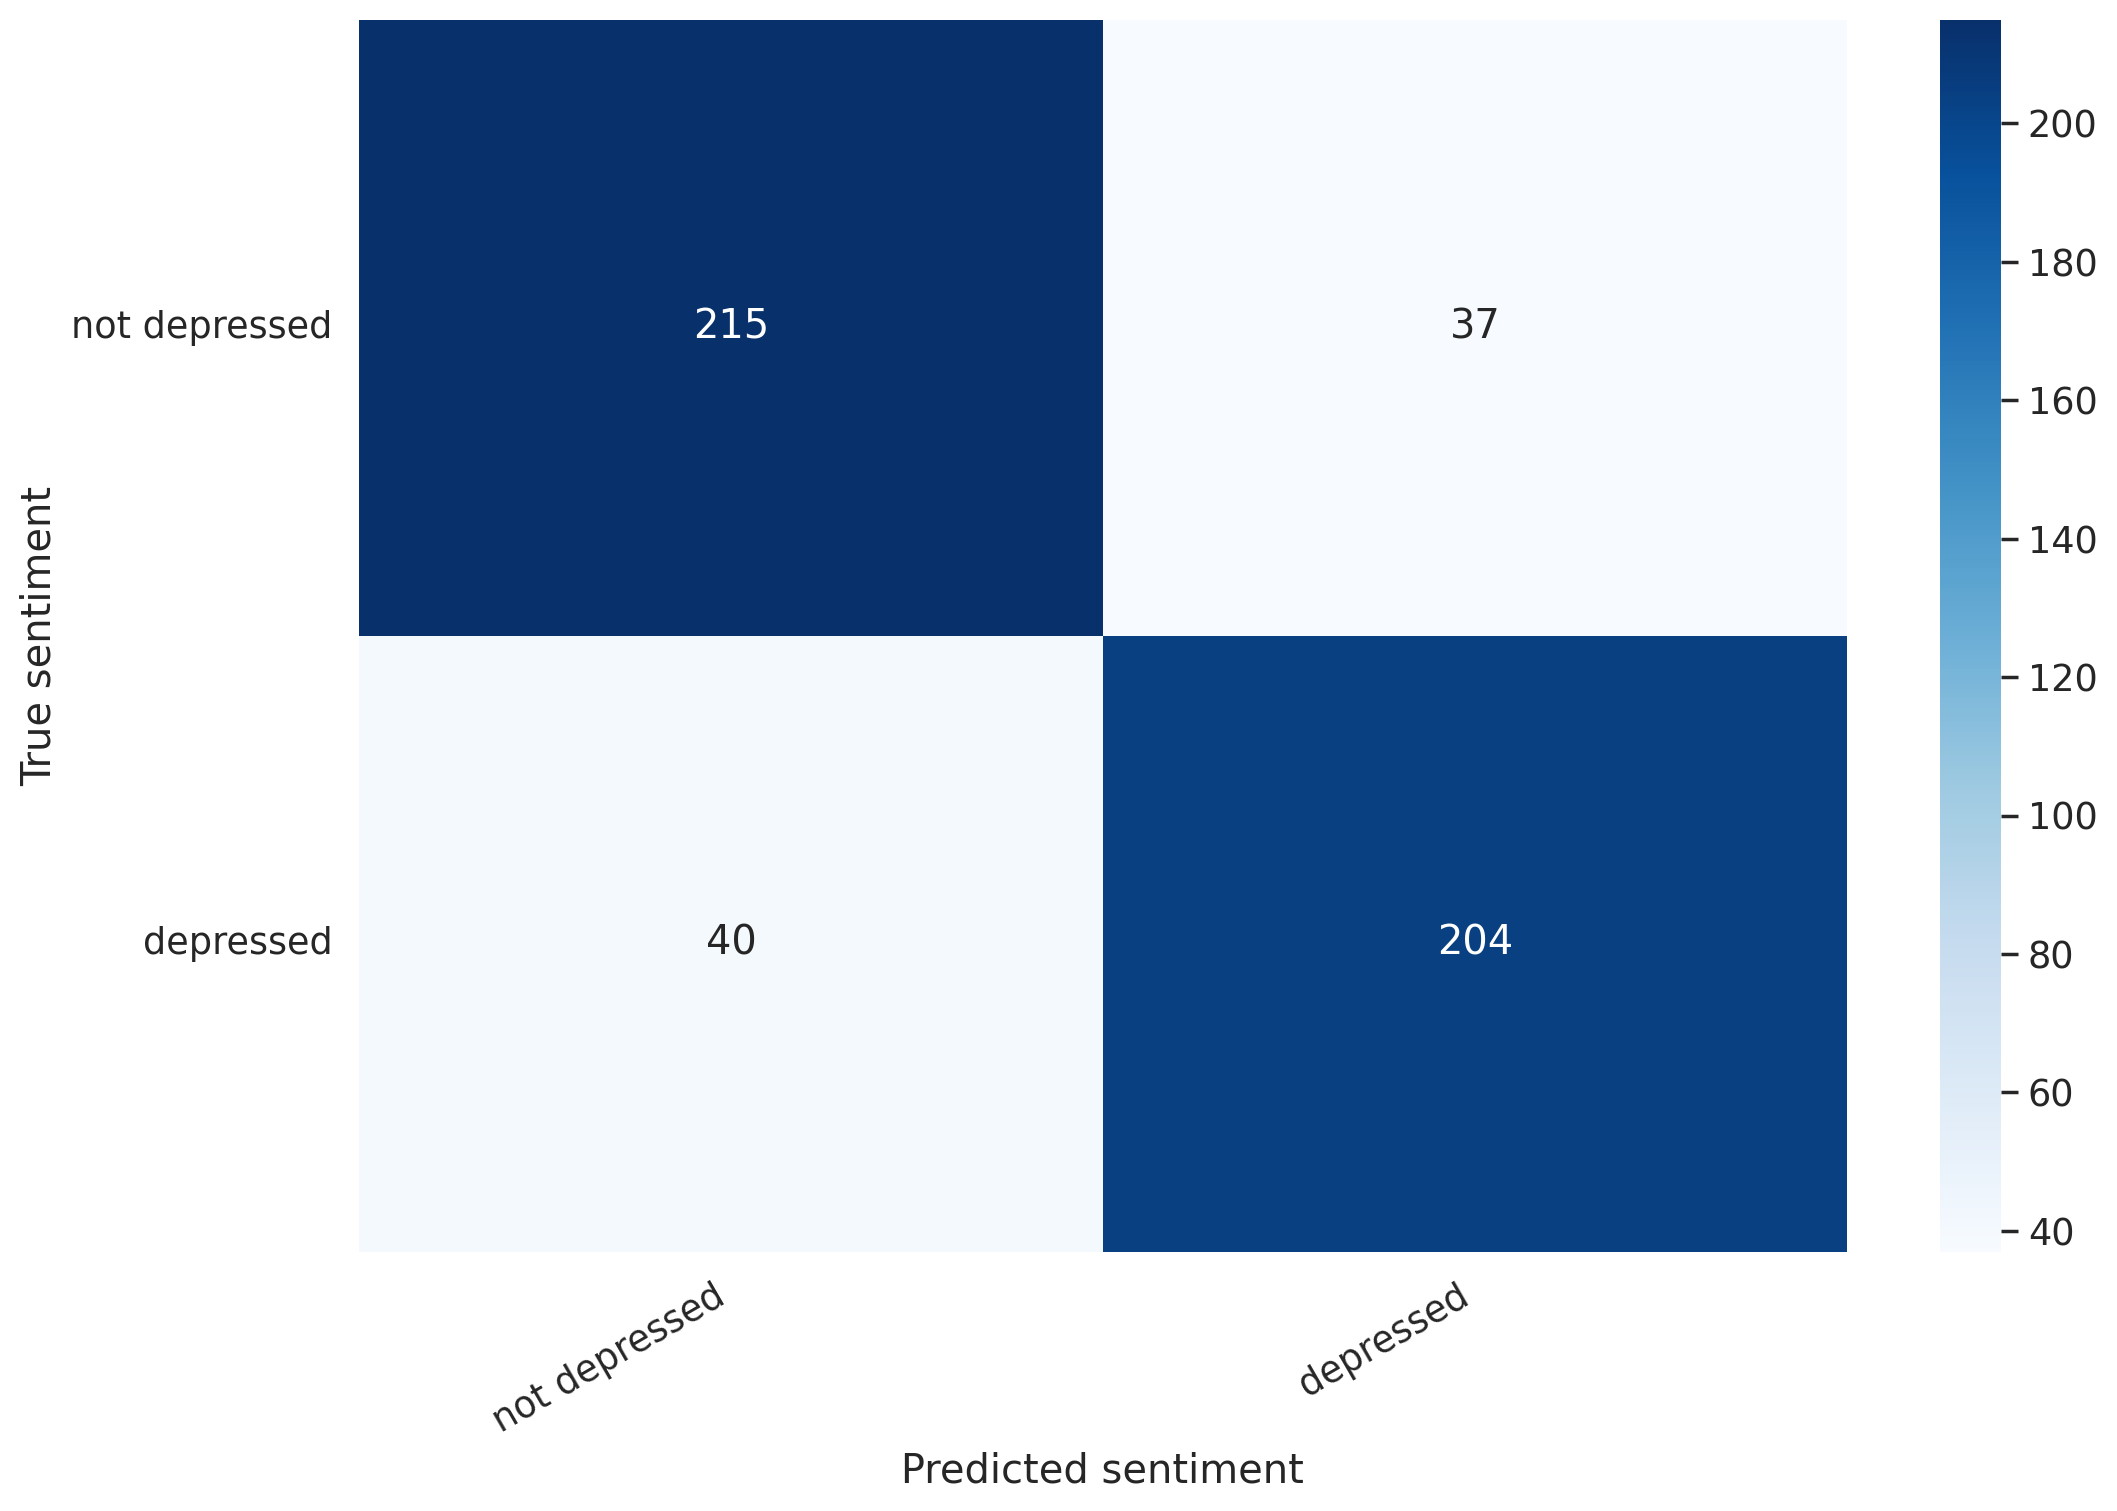

In [38]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [39]:
torch.save(model.state_dict(), "WEBEATTHEPAPER.pt")

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I have depression h"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
model = torch.load("model.pt", map_location=torch.device('cpu'))

print(type(model))

In [ ]:

model = SentimentClassifier(len(class_names))
model.load_state_dict(test)

